In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import scipy.stats as st
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [2]:
pdf = pd.read_csv('../../masked/patients_info.csv', index_col=0)
pdf['Molecular_Subtype'] = pdf['HER2_Status']+pdf['ER_Status']

tpm = pd.read_csv('../../masked/rna.csv', index_col=0)
tpm

,A1BG,A1BG-AS1,A1CF,A2M,A2M-AS1,A2ML1,A2ML1-AS1,A2ML1-AS2,A2MP1,A3GALT2,...,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11A,ZYG11AP1,ZYG11B,ZYX,ZYXP1,ZZEF1
ID,,,,,,,,,,,,,,,,,,,,,
PS001,2.554545,3.375340,0.102582,671.009277,6.477034,0.030823,0.000000,0.000000,0.246188,0.130168,...,1.351429,5.488099,5.980098,13.382974,0.221987,0.0,23.357113,78.242569,0.0,16.917589
PS002,3.973684,8.084476,0.000000,482.736603,11.487203,0.567516,0.167414,0.000000,2.122550,0.709813,...,4.096071,9.684871,11.393213,23.624439,2.115061,0.0,14.649521,117.439857,0.0,39.268021
PS003,2.657011,3.417682,0.026238,151.547119,1.579410,0.041024,0.000000,0.000000,0.031227,0.105220,...,10.572713,3.408053,4.684459,8.854721,3.067032,0.0,8.693533,65.290184,0.0,15.642656
PS004,1.705158,3.331902,0.008057,996.875488,3.210443,0.014332,0.095044,0.000016,0.128665,0.623898,...,1.103520,5.452625,7.929631,14.944577,0.090629,0.0,19.690754,155.475510,0.0,45.001125
PS006,1.863930,3.715610,0.000000,653.799011,1.821601,0.082374,0.060805,0.000000,0.019363,0.108891,...,11.391800,4.558637,5.403933,10.564625,1.198333,0.0,20.389639,138.062851,0.0,18.970005
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
PS145,1.549966,4.952771,0.000000,259.307098,4.898162,31.927877,0.642495,0.998744,0.242057,0.296059,...,6.398725,3.061711,4.763528,7.707039,0.503232,0.0,11.359871,50.807503,0.0,17.367798
PS146,2.781682,4.861745,0.029085,156.142365,4.307828,1.511595,0.204680,0.194927,0.068489,0.132219,...,11.494687,2.122599,2.952411,14.829761,4.534321,0.0,13.221382,45.656532,0.0,14.674788
PS147,3.986495,6.512741,0.000000,196.518387,2.147338,5.990981,0.123039,0.009727,0.027835,0.104827,...,8.046101,2.888004,5.099798,9.811412,1.319361,0.0,11.972345,99.761963,0.0,14.005712


In [3]:
import gseapy as gp

gene_sets="/Users/zzhuay/GSEA_4.1.0/ref/msigdb.hallmark.gmt"
ss_ggh = gp.ssgsea(data=(tpm.T+0.01).apply(np.log2).T.apply(st.zscore).T,
               gene_sets=gene_sets,
               outdir='./tmp',
               min_size=1, max_size=1000,
               sample_norm_method='rank', # choose 'custom' for your own rank list
               permutation_num=0, # skip permutation procedure, because you don't need it
               no_plot=True, # skip plotting, because you don't need these figures
               processes=12, format='png', seed=1)

2022-11-14 17:33:00,836 Warning: Input data contains NA, filled NA with 0


In [4]:
ss_ggh.res2d.T.to_csv('../../masked/ssrna_check.csv')

In [5]:
def diff(pd_df, label, value, method):
    from scipy.stats import ranksums, ttest_ind
    from sklearn.metrics import roc_auc_score
    symbol = []
    res = []
    res2 = []
    median_case = []
    median_ctr = []
    case = pd_df[pd_df[label]==value]
    ctr = pd_df[pd_df[label]!=value]
    
    for i in pd_df.drop(columns=label).columns:
        if method == 'rank':
            res.append(ranksums(case[i],ctr[i]).pvalue)
        elif method == 'ttest':
            res.append(ttest_ind(case[i],ctr[i]).pvalue)
        elif method == 'auc':
            res.append(roc_auc_score(pd_df[label]==value, pd_df[i]))
            res2.append(ranksums(case[i],ctr[i]).pvalue)
            
        symbol.append(i)
        median_case.append((case[i]).median())
        median_ctr.append((ctr[i]).median())
        
    all_df = pd.DataFrame()
    all_df['SYMBOL'] = symbol
    all_df['Median_Case'] = median_case
    all_df['Median_Ctr'] = median_ctr
    all_df['Diff'] =  all_df['Median_Case']-all_df['Median_Ctr']
    all_df['Result'] = res
    all_df['Pval'] = res2
    return all_df

In [6]:
for i in ss_ggh.res2d.index:
    tpm[i] = ss_ggh.res2d.T[i]

In [7]:
tpm['Molecular_Subtype'] = tpm.index.map(pdf['Molecular_Subtype'])
tpm['pCR'] = tpm.index.map(pdf['pCR'])

In [8]:
s3_ggh = diff(tpm[tpm['Molecular_Subtype']=='PosPos']\
               [['pCR']+list(ss_ggh.res2d.index)], 'pCR', 1, 'auc')
s3_ggh.sort_values('Pval')[:10]

,SYMBOL,Median_Case,Median_Ctr,Diff,Result,Pval
22,HALLMARK_IL2_STAT5_SIGNALING,0.129157,0.041403,0.087754,0.706147,0.011298
10,HALLMARK_COMPLEMENT,0.105016,0.042156,0.062860,0.700150,0.013908
25,HALLMARK_INTERFERON_ALPHA_RESPONSE,0.199278,0.012484,0.186794,0.685157,0.022882
23,HALLMARK_IL6_JAK_STAT3_SIGNALING,0.089835,0.003736,0.086099,0.685157,0.022882
45,HALLMARK_UNFOLDED_PROTEIN_RESPONSE,0.154359,0.089854,0.064505,0.685157,0.022882
24,HALLMARK_INFLAMMATORY_RESPONSE,0.103297,0.004846,0.098450,0.673163,0.033337
36,HALLMARK_P53_PATHWAY,0.135703,0.068407,0.067296,0.668666,0.038198
6,HALLMARK_APOPTOSIS,0.140026,0.082570,0.057456,0.665667,0.041762
39,HALLMARK_PI3K_AKT_MTOR_SIGNALING,0.142099,0.092949,0.049150,0.665667,0.041762
26,HALLMARK_INTERFERON_GAMMA_RESPONSE,0.135225,0.007333,0.127892,0.664168,0.043648


In [9]:
s4_ggh = diff(tpm[tpm['Molecular_Subtype']=='PosNeg']\
               [['pCR']+list(ss_ggh.res2d.index)], 'pCR', 1, 'auc')
s4_ggh.sort_values('Pval')[:10]

,SYMBOL,Median_Case,Median_Ctr,Diff,Result,Pval
27,HALLMARK_KRAS_SIGNALING_DN,0.076658,0.124420,-0.047762,0.251852,0.025527
24,HALLMARK_INFLAMMATORY_RESPONSE,0.180456,0.138803,0.041653,0.666667,0.133614
5,HALLMARK_APICAL_SURFACE,0.131050,0.091858,0.039192,0.666667,0.133614
25,HALLMARK_INTERFERON_ALPHA_RESPONSE,0.120707,-0.058390,0.179097,0.644444,0.193601
26,HALLMARK_INTERFERON_GAMMA_RESPONSE,0.179394,0.070765,0.108629,0.622222,0.271332
30,HALLMARK_MTORC1_SIGNALING,0.154420,0.105617,0.048804,0.622222,0.271332
1,HALLMARK_ALLOGRAFT_REJECTION,0.187014,0.140035,0.046979,0.618519,0.286122
41,HALLMARK_REACTIVE_OXYGEN_SPECIES_PATHWAY,0.121667,0.089662,0.032005,0.614815,0.301448
8,HALLMARK_CHOLESTEROL_HOMEOSTASIS,0.184313,0.118043,0.066270,0.614815,0.301448
15,HALLMARK_ESTROGEN_RESPONSE_LATE,0.117407,0.083442,0.033965,0.611111,0.317311


In [10]:
s5_ggh = diff(tpm[tpm['Molecular_Subtype']=='NegNeg']\
               [['pCR']+list(ss_ggh.res2d.index)], 'pCR', 1, 'auc')
s5_ggh.sort_values('Pval')[:10]

,SYMBOL,Median_Case,Median_Ctr,Diff,Result,Pval
12,HALLMARK_E2F_TARGETS,0.242809,0.051280,0.191530,0.686667,0.025091
17,HALLMARK_G2M_CHECKPOINT,0.223862,0.092383,0.131479,0.685000,0.026419
47,HALLMARK_UV_RESPONSE_UP,0.129203,0.074712,0.054491,0.660000,0.054858
29,HALLMARK_MITOTIC_SPINDLE,0.157349,0.104098,0.053250,0.640000,0.092957
30,HALLMARK_MTORC1_SIGNALING,0.127184,0.027371,0.099813,0.628333,0.123560
42,HALLMARK_SPERMATOGENESIS,0.113435,0.092900,0.020535,0.620000,0.149867
46,HALLMARK_UV_RESPONSE_DN,0.080939,0.121996,-0.041057,0.385000,0.167587
33,HALLMARK_MYOGENESIS,0.083392,0.126772,-0.043380,0.400000,0.230139
24,HALLMARK_INFLAMMATORY_RESPONSE,0.163065,0.058507,0.104559,0.598333,0.238000
31,HALLMARK_MYC_TARGETS_V1,0.176653,0.066793,0.109859,0.595000,0.254286


In [11]:
def color(df):    
    return 1*(df['Pval']<0.05)*(df['Diff']>0.05) - 1*(df['Pval']<0.05)*(df['Diff']<-0.05) 

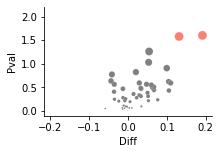

In [12]:
plt.subplots(figsize=[3,2])
sns.scatterplot(s5_ggh['Diff'], -s5_ggh['Pval'].apply(np.log10), c=s5_ggh.apply(color, axis=1).map({0:'grey',-1:sns.color_palette("Set3")[4],1:sns.color_palette("Set3")[3],}), s=-50*s5_ggh['Pval'].apply(np.log10))
plt.xlim([-0.215,0.215])
plt.ylim([-0.1,2.2])
sns.despine(left=False, bottom=False, right=True, top=True)
plt.savefig('../figures/ssgsea_'+'NegNeg'+'.pdf', bbox_inches='tight')

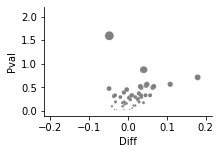

In [13]:
plt.subplots(figsize=[3,2])
sns.scatterplot(s4_ggh['Diff'], -s4_ggh['Pval'].apply(np.log10), c=s4_ggh.apply(color, axis=1).map({0:'grey',-1:sns.color_palette("Set3")[4],1:sns.color_palette("Set3")[3],}), s=-50*s4_ggh['Pval'].apply(np.log10))
plt.xlim([-0.215,0.215])
plt.ylim([-0.1,2.2])
sns.despine(left=False, bottom=False, right=True, top=True)
plt.savefig('../figures/ssgsea_'+'PosNeg'+'.pdf', bbox_inches='tight')

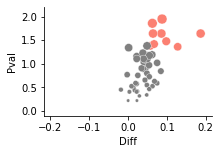

In [14]:
plt.subplots(figsize=[3,2])
sns.scatterplot(s3_ggh['Diff'], -s3_ggh['Pval'].apply(np.log10), c=s3_ggh.apply(color, axis=1).map({0:'grey',-1:sns.color_palette("Set3")[4],1:sns.color_palette("Set3")[3],}), s=-50*s3_ggh['Pval'].apply(np.log10))
plt.xlim([-0.215,0.215])
plt.ylim([-0.1,2.2])
sns.despine(left=False, bottom=False, right=True, top=True)
plt.savefig('../figures/ssgsea_'+'PosPos'+'.pdf', bbox_inches='tight')